<h1 style="font-size:30px;">Check Training Pipeline</h1>


Some aspects of the Training Pipeline have already been discussed in one of our videos on `Training Deep Networks`.


## Table of Contents

- [1 Fix Random Seed](#1-Fix-Random-Seed)
- [3 Use a Simple Baseline Model](#3-Use-a-Simple-Baseline-Model)
- [4 Turn-off  Data Augmentation](#4-Turn-off--Data-Augmentation)
- [5 Visualize Input Data Before It Goes Inside the Network](#5-Visualize-Input-Data-Before-It-Goes-Inside-the-Network)
- [6 Check Initial Loss and Accuracy](#6-Check-Initial-Loss-and-Accuracy)
- [7 Does Loss Goes Down at Every Epoch?](#7-Does-Loss-Goes-Down-at-Every-Epoch?)
- [8 Forward the Same Batch for Multiple Interations and Check if Loss Drops Near to 0](#8-Forward-the-Same-Batch-for-Multiple-Interations-and-Check-if-Loss-Drops-Near-to-0)
- [9 Forward Pass a Zero Input and Check If Loss is High](#9-Forward-Pass-a-Zero-Input-and-Check-If-Loss-is-High)
- [10 Calculate the Loss on Entire Test-Set](#10-Calculate-the-Loss-on-Entire-Test-Set)
- [11 Check Dimensions Using Backprop](#11-Check-Dimensions-Using-Backprop)
- [Reference](#References)

In [1]:
import os
import requests
from zipfile import ZipFile, BadZipFile
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def system_config(SEED_VALUE=42, package_list=None):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. Default is 42.
        package_list (str): String containing a list of additional packages to install
        for Google Colab or Kaggle. Default is None.

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ

    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #---------------------------------
    # Check for availability of GPUs.
    #---------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')

        # This section for installing packages required by Colab.
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}

        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = True # Insures deterministic even when above cudnn is enabled.
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print('Using Apple Silicon GPU')

        # Set the device to the Apple Silicon GPU Metal Performance Shader (MPS).
        DEVICE = torch.device("mps")
        print("Device: ", DEVICE)
        # Environment variable that allows PyTorch to fall back to CPU execution
        # when encountering operations that are not currently supported by MPS.
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        GPU_AVAILABLE = True

        torch.mps.manual_seed(SEED_VALUE)
        torch.use_deterministic_algorithms(True)

    else:
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False

        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}
            print('Note: Change runtime type to GPU for better performance.')

        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [3]:
DEVICE, GPU_AVAILABLE = system_config()

Using CPU
Device:  cpu
Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2
Note: Change runtime type to GPU for better performance.


## 1 Fix Random Seed

We deal with only one numeric computational library i.e. PyTorch. So we'll set its random seed.

The code follows:

## Download and Extract Data

In [4]:
def download_file(url, save_name):
    response = requests.get(url, stream=True)
    with open(save_name, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Downloaded: {save_name}")

In [5]:
def unzip(zip_file_path=None):
    try:
        with ZipFile(zip_file_path, 'r') as z:
            z.extractall("./")
            print(f"Extracted: {os.path.splitext(zip_file_path)[0]}\n")
    except FileNotFoundError:
        print("File not found")
    except BadZipFile:
        print("Invalid or corrupt zip file")
    except Exception as e:
        print(f"Error occurred: {e}")

    return

In [6]:
URL = r"https://www.dropbox.com/scl/fi/5he9lu6j4jvnpnct4rxnf/dataset_caltech_101_subset.zip?rlkey=a69xlsrzvd4m1u3okutt6h4h8&dl=1"

archive_name = "dataset_caltech_101_subset"

zip_name = f"./{archive_name}.zip"

if not os.path.exists(archive_name):

    download_file(URL, zip_name)
    unzip(zip_name)

Downloaded: ./dataset_caltech_101_subset.zip
Extracted: ./dataset_caltech_101_subset



## 3 Use a Simple Baseline Model

Here, we shall use a simple dataset to discuss 10 points.. This dataset is a small subset of the `Caltech-101` data. You can download the data from https://data.caltech.edu/records/mzrjq-6wc02


This subset data spans 4 classes i.e. `[chandelier, watch, laptop, motorbike]`, having around 400 images.

Use a simple Image Classification network, which has  few convolutional and linear layers. The input size will be `(3, 160, 160)` and the output nodes `4`.

Let's define a simple model in the following block.

In [7]:
class Net(nn.Module):
    def __init__(self,n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 32, 3, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1)
        self.fc1 = nn.Linear(10368, 2048)
        self.fc2 = nn.Linear(2048,128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## 4 Turn-off  Data Augmentation

Sometimes, we use augmentation techniques, such as random-rotation, adding small noise, translating the image etc. But when we  ensure reproducibility, we do not need such techniques. Only use Resizing, Cropping and Normalization as they are deterministic.

The images in the data are of various sizes. We whereas the model  fix the input size to `(160,160)`, in line with what our model expects.


We will also need a generator to  supply the batch of images required for training. PyTorch provides a good handle for this as well. Don't worry if you don't understand the code below. It takes care of the preprocessing step (without any augmentation), and gives us the data-generator that we must feed to the neural network. At this point, you need not know beyond this. More on the code in later lectures.

In [8]:
from torchvision import datasets, transforms

preprocess = transforms.Compose([transforms.Resize((196,196)),transforms.CenterCrop((160,160)),
                                 transforms.ToTensor()])

# data_root = f"caltech_subset"
data_root = archive_name

train_data_path = os.path.join(data_root, 'train')
test_data_path = os.path.join(data_root, 'test')


train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root=train_data_path, transform=preprocess),
    batch_size=16,
    shuffle=True,
    num_workers=2)



test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root=test_data_path, transform=preprocess),
    batch_size=16,
    shuffle=False,
    num_workers=2
)

## 5 Visualize Input Data Before It Goes Inside the Network

This step ensures the input goes inside the network as expected. It's just a sanity-check. Use image-visualizing libraries like `PIL`, `OpenCV` or `Matplotlib` to do this. And  the train_loader to  get batches of images. Pick some samples and plot them. Omit  `transforms.Normalize()`, if you plan using it in the pre-processing step. Because if there is normalization,, the pixel values will not be in the range of `0-255`.


Follow  this code to visualize some of the images:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


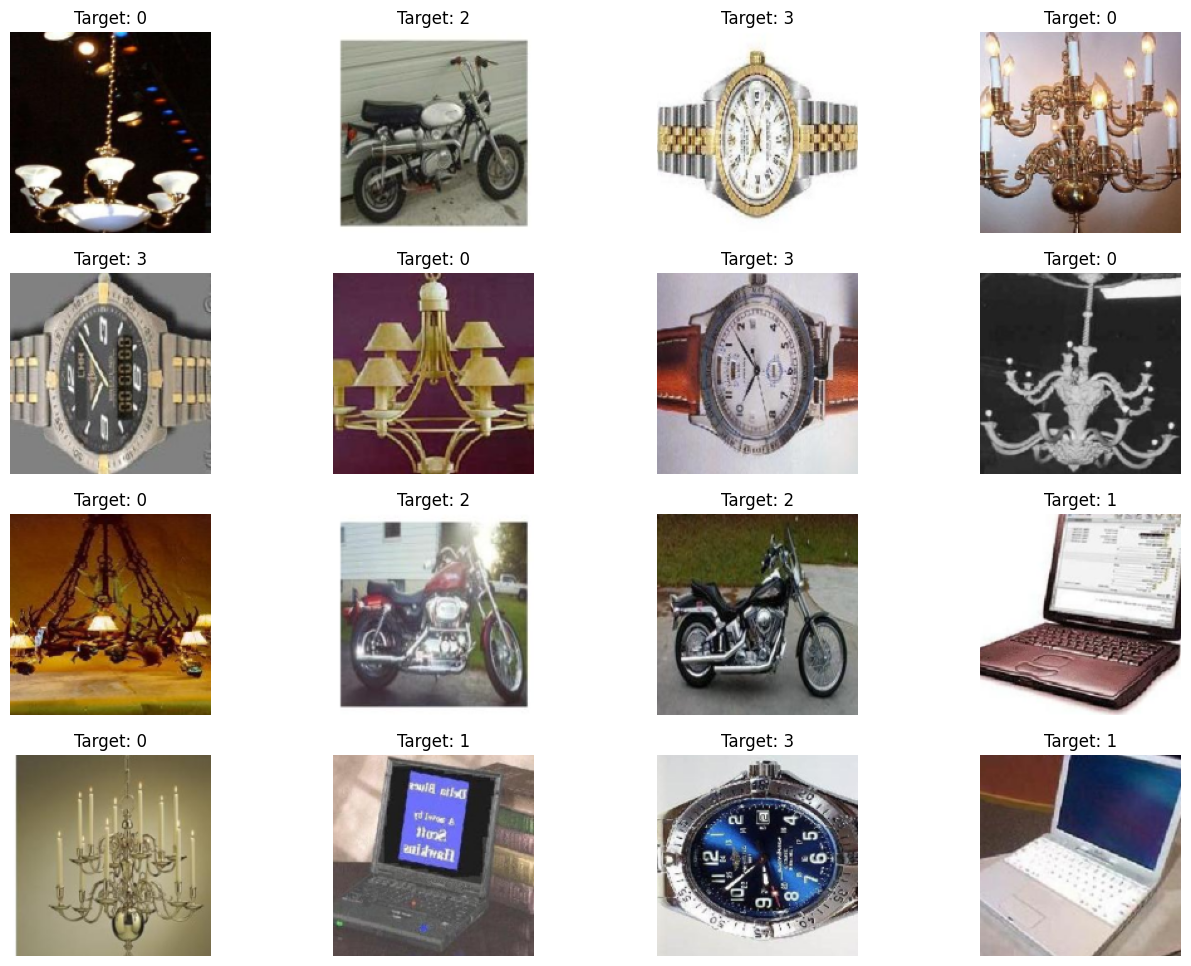

In [9]:
plt.rcParams["figure.figsize"] = (16, 12)
plt.figure
for images, labels in train_loader:
    for i in range(len(labels)):
        plt.subplot(4, 4, i+1)
        img = transforms.functional.to_pil_image(images[i])
        plt.imshow(img)
        plt.axis('off')
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

## 6 Check Initial Loss and Accuracy

**Is the model initialized randomly?** Verify. The **initial loss** should be around `ln(num_classes)` and **accuracy** about  `1/num_classes`.

Now,create a class `CheckInitLossAndAccuracy` and  verify the `5th` point, by calculating the loss and accuracy. You  will need the following arguments:


We will need the following arguments:-
1. A randomly initialized model.
2. A batch of input.
3. A batch of  target classes.
4. Number of classes.


The class has two methods:
- `verify_init_loss` verifies if the initial loss is around `ln(num_classes)`

- `verify_init_accuracy` verifies if the initial accuracy is around `1/num_classes`

In [10]:
class CheckInitLossAndAccuracy():
    def __init__(self, net, x, num_classes, target = None):
        self.net = net
        self.x = x
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = self.x.size()[0]
        if target is None:
            self.target = torch.randint(0, self.num_classes, size=(self.batch_size,))
        else:
            self.target = target
        self.logits = self.net(self.x)

    def verify_init_loss(self):
        loss = self.criterion(self.logits, self.target)
        print("Expected loss is ", np.log(self.num_classes))
        print("Inferred loss is ", loss.item())
        return None

    def verify_init_accuracy(self):
        predictions = torch.argmax(F.softmax(self.logits, dim=1), axis=1)
        accuracy = accuracy_score(self.target, predictions.detach())
        print("Expected accuracy is ", 1 / self.num_classes)
        print("Inferred accuracy is ", accuracy)
        return None


In [11]:
from sklearn.metrics import accuracy_score

n = 4
x, target = next(iter(train_loader))

print("num classes are ", n)
model = Net(n)
check = CheckInitLossAndAccuracy(model, x, n, target)
check.verify_init_loss()
check.verify_init_accuracy()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


num classes are  4
Expected loss is  1.3862943611198906
Inferred loss is  1.375444769859314
Expected accuracy is  0.25
Inferred accuracy is  0.4375


**Look at the numbers, they are almost equal!**

## 7 Does Loss Goes Down at Every Epoch?

Check it out by setting up a training procedure that is typical to  a neural network. Store the loss values in a list or an array. Visualize it once the training gets over.

Follow this code to do this:

In [12]:
import torch.optim as optim

num_classes = 4
model1 = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum = 0.9)


loss_list = []
num_epochs = 10
for epoch in range(num_epochs):
    per_epoch_loss= 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = data
        logits = model1(x)
        loss = criterion(logits, target)
        temp_loss = loss.item()
        per_epoch_loss+=temp_loss
        loss.backward()
        optimizer.step()

    per_epoch_avg_loss = per_epoch_loss/(i+1)
    loss_list.append(per_epoch_avg_loss)
    print("Loss at epoch {0} = {1}".format(epoch+1, per_epoch_avg_loss ))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss at epoch 1 = 1.3832917461792629
Loss at epoch 2 = 1.3817396412293117
Loss at epoch 3 = 1.3805983165899913
Loss at epoch 4 = 1.3799431125322978
Loss at epoch 5 = 1.378867546717326
Loss at epoch 6 = 1.3767227580149968
Loss at epoch 7 = 1.3794587055842082
Loss at epoch 8 = 1.376104439298312
Loss at epoch 9 = 1.3755567769209545
Loss at epoch 10 = 1.3746744443972905


**You  kept track of the `loss`, at every epoch in the `loss_list`. Let's use them to plot the loss-curve.**

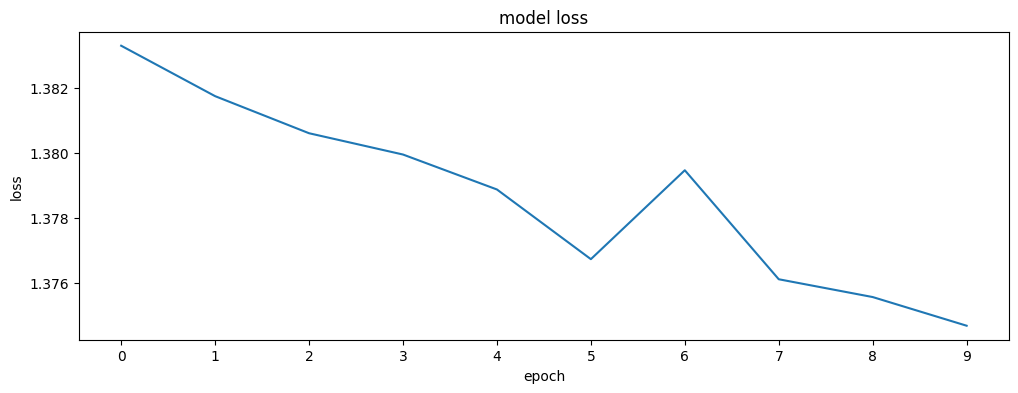

In [13]:
plt.figure(figsize = (12,4))
plt.plot(loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,10))
plt.show()

The loss-curve shows that the loss is indeed plummeting.

## 8 Forward the Same Batch for Multiple Interations and Check if Loss Drops Near to 0

Use the above code for this too., Only do not  iterate over the batch. Just forward the same and monitor the loss.

The code follows:

In [14]:
import torch.optim as optim

num_classes = 4
model2 = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

x, target = next(iter(train_loader))


loss_list = []
num_iters = 25
for i in range(num_iters):
    optimizer.zero_grad()
    logits = model2(x)
    loss = criterion(logits, target)
    temp_loss = loss.item()
    loss.backward()
    optimizer.step()
    loss_list.append(temp_loss)
    print("Loss at iteration-{} is {}".format(i+1,temp_loss))

Loss at iteration-1 is 1.3889318704605103
Loss at iteration-2 is 1.3735207319259644
Loss at iteration-3 is 1.3972461223602295
Loss at iteration-4 is 1.3583978414535522
Loss at iteration-5 is 1.3616975545883179
Loss at iteration-6 is 1.3456307649612427
Loss at iteration-7 is 1.3139686584472656
Loss at iteration-8 is 1.2670406103134155
Loss at iteration-9 is 1.1902053356170654
Loss at iteration-10 is 1.0506619215011597
Loss at iteration-11 is 0.855402946472168
Loss at iteration-12 is 0.6659685373306274
Loss at iteration-13 is 1.1564576625823975
Loss at iteration-14 is 0.5548757314682007
Loss at iteration-15 is 0.8150988221168518
Loss at iteration-16 is 0.3370248079299927
Loss at iteration-17 is 0.39137500524520874
Loss at iteration-18 is 0.44307827949523926
Loss at iteration-19 is 0.36652854084968567
Loss at iteration-20 is 0.24008868634700775
Loss at iteration-21 is 0.1589282751083374
Loss at iteration-22 is 0.14721164107322693
Loss at iteration-23 is 0.13599248230457306
Loss at iterati

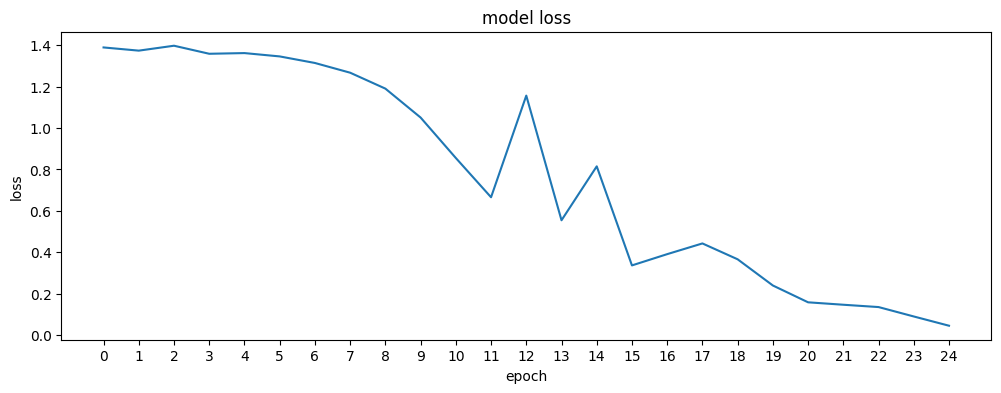

In [15]:
# Let's plot the loss curve.

plt.figure(figsize = (12,4))
plt.plot(loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,i+1))
plt.show()

## 9 Forward Pass a Zero Input and Check If Loss is High

For this, we will use a model trained in 6th point i.e. `model1`, and look at the loss. The `input` or `x` to this model will be Tensors of zeros,  and the `target` will be a set of random numbers between `0` and `3`.
We got a final loss of `1.3746`, at the `10th` epoch, in `section-6` , so we expect the zero-valued input shall produce a much higher loss than this.

In [16]:
criterion = nn.CrossEntropyLoss()

x = torch.zeros(size = (16,3,160,160))
target = torch.randint(0,4,size = (16,))
logits = model1(x)

loss = criterion(logits,target)
print("Loss with zero-valued input is ", loss.item())

Loss with zero-valued input is  1.401158332824707


## 10 Calculate the Loss on Entire Test-Set

For this, we already have a generator called the `test_loader`. Everytime we want to test our model's performance, we use it. The following code will calculate the test loss, on the entire test set, every 2 epochs. You can however calculate it at every epoch as well. It’s the user who determines how frequently the loss needs to be logged.


Use the code that is given in the section `6` above. Just add, a few extra lines  to calculate the test-loss. Here, it is:

In [17]:
import torch.optim as optim

num_classes = 4
model3 = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)


loss_list = []
num_epochs = 10
for epoch in range(num_epochs):
    per_epoch_loss= 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = data
        model3.train()
        logits = model3(x)
        loss = criterion(logits, target)
        temp_loss = loss.item()
        per_epoch_loss+=temp_loss
        loss.backward()
        optimizer.step()
    per_epoch_avg_loss = per_epoch_loss/(i+1)
    loss_list.append(per_epoch_avg_loss)
    print("Traning loss at epoch {} = {}".format(epoch+1, per_epoch_avg_loss ))

    if(epoch+1)%2==0:
        total_test_loss = 0
        with torch.no_grad():
            model3.eval()
            for j, test_data in enumerate(test_loader):
                test_x, test_target = test_data
                test_logits = model3(test_x)
                test_loss = criterion(test_logits, test_target)
                total_test_loss+= test_loss.item()
            print("Test loss at epoch {} = {}".format(epoch+1, total_test_loss/(j+1)))


Traning loss at epoch 1 = 1.3870956003665924
Traning loss at epoch 2 = 1.385243644316991
Test loss at epoch 2 = 1.3804760873317719
Traning loss at epoch 3 = 1.3829457213481267
Traning loss at epoch 4 = 1.3821357538302739
Test loss at epoch 4 = 1.3760733604431152
Traning loss at epoch 5 = 1.3812734832366307
Traning loss at epoch 6 = 1.3795505315065384
Test loss at epoch 6 = 1.373349368572235
Traning loss at epoch 7 = 1.3780562728643417
Traning loss at epoch 8 = 1.3778591205676396
Test loss at epoch 8 = 1.3710737526416779
Traning loss at epoch 9 = 1.3760293871164322
Traning loss at epoch 10 = 1.375441571076711
Test loss at epoch 10 = 1.368282973766327


## 11 Check Dimensions Using Backprop

Let's take a concrete example and break down the points discussed in the video,.

1. Consider a simple network with just a few convolutional and linear layers, whose input shape is `(1,28,28)` and output shape is 10.


2. Take the batch size to be 25. The input size will then be `(25,1,28,28)` and the output `(25,10)`.


3. Once you get  the output, plug it  inside the Loss function to get a loss. Typically, this loss is just one number (a scalar), which is either summed or averaged over the `25` loss values. However, you can get the unsummed and unaveraged loss-values, by passing `reduction='none'`, when instantiating `nn.CrossEntropyLoss()`. Now, if we evaluate the loss, it would not be a scalar, but a vector of `25` entries, where each entry corresponds to the loss for each image in the batch.


4. As discussed in the video, keep only **one entry (eg. `11th` entry)** in this `25-d` loss-vector intact. Set the remaining `24` entries to zero. Then calculate the gradients via backpropagation from this modified loss.


5. After backpropagation, its gradients can be accessed. At this point, note that the gradients should be of size `(25, num_weights)`. Each entry in the first dimension must correspond to the gradients for each image.


We claimed that if the dimensions are right, then all the gradients, except that in the `11th` entry will be zero.  No need to check   the entries for this.  Just sum up the gradients along the batch (first) dimension, and look at the resulting `25` numbers. You will see  that the index with the highest number is `11`, indicating that the gradients at the `11th` entry are non-zero.




If the dimensions are not right, then the index will not be 11.

**NOTE**

In order to verify this claim using code, there is a small bottleneck.

PyTorch expects loss to be scalar, it will throw an error, if a Tensor ( in our case, if a `25-d` vector ) is passed.

And due to this, the gradients which we can access after `loss.backward()` will be of size `(num_weights,)` and not `(25, num_weights)`, i.e. the gradients will be calculated from the sum or average,  over the 25 entries of the loss values.


But no worries, we will show you a work-around for this.


   
Follow these two steps:

**STEP-1** `get_batched_gradients_metric`

1. Follow the same steps, till the `4th` point -.. Keep only the `11th` entry intact. Set the rest to `0`. Then, SUM-THEM-UP. Now,  we have a scalar, which we can easily backprop.

2. After backprop, the gradients are expected to be of size `(num_weights,)`. But we are not sure if these gradients really belonged to the `11th` image. Verify this with an additional step.,

3. Also, let's not look at the whole set of gradients. Instead, consider  the absolute-sum, it will be much easier to compare.


**STEP-2** (as a verification method for step-1 ) `get_individual_gradients_metric`

1. Follow the same steps till the `4th` point. Keeping only the `11th` entry intact. Set the rest to 0. Instead of summing up the loss-vector and bringing it to a scalar, let’s do it in an iterative way for the whole batch.


2. For each image in the batch, we backprop, with its corresponding loss. This essentially means except the `11th` image, all all loss entries will be zero. We will also keep track of the absolute sum of gradients for each image.


3. Once the iteration on the batch is over, we will have `25` such gradient-sums.


In `step-2`,  all  every gradient-sum, except that at the 11th entry will be zero. Also, the non-zero value of the `11th` entry must be exactly equal to the number we get in `step-1`.

Thus indicating that only the `11th` entry has gradients. This in turn means that the dimensions are correct.



We will use the class `Check_dims_via_backprop` to verify the `10th` point. The class expects the following parameters:


1. Input batch

2. The Network-class

3. Target batch

4. A random number that indicates, which image in the batch we want to experiment with.

Execute two steps to verify the above statement.

1. The method `get_batched_gradients_metric()` will give us the gradient-sum as mentioned in STEP-1.


2. The method `get_individual_gradients_metric()` will give us the gradient-sum for each image as mentioned in STEP-2

In [18]:
class CheckDimsViaBackprop():
    def __init__(self, net_class, x, num_classes, target=None, selected_sample_index=11):
        self.first_model = None
        self.net_class = net_class
        self.x = x
        self.num_classes = num_classes
        self.batch_size = self.x.size()[0]
        self.selected_sample_index = selected_sample_index
        if target is None:
            self.target = torch.randint(0, self.num_classes, size=(self.batch_size,))
        else:
            self.target = target

    def get_batched_gradients_metric(self):
        first_model = self.net_class(self.num_classes)
        self.first_model = first_model
        criterion = nn.CrossEntropyLoss(reduction='none')

        logits = first_model(self.x)
        loss = criterion(logits, self.target)

        mask = torch.zeros_like(loss)
        mask[self.selected_sample_index] = 1
        loss *= mask
        loss = loss.sum()
        loss.backward()
        grad_metric = abs(sum([p.grad.numpy().sum() for p in list(first_model.parameters())]))
        print("Batched Gradient metric =  ", grad_metric)
        return None

    def get_individual_gradients_metric(self):
        second_model = self.net_class(self.num_classes)
        second_model.load_state_dict(self.first_model.state_dict())

        criterion = nn.CrossEntropyLoss(reduction='none')
        logits = second_model(self.x)
        loss = criterion(logits, self.target)

        mask = torch.zeros_like(loss)
        mask[self.selected_sample_index] = 1
        loss *= mask
        temp_loss = loss.clone()

        for i in range(len(temp_loss)):
            second_model.zero_grad()
            temp_img = self.x[i, ...]
            op = second_model(torch.unsqueeze(temp_img, 0))
            temp_target = torch.Tensor([self.target[i]]).long()
            loss = criterion(op, temp_target)
            loss = temp_loss[i]
            loss.backward(retain_graph=True)
            grads = [p.grad.numpy().sum() for p in list(second_model.parameters())]
            grad_metric = abs(sum(grads))
            if grad_metric > 0:
                print("Gradient metric at sample {} =  ".format(i), grad_metric)
        return None


The following example uses the above class. As usual, we grab a batch from the `train_loader`,and experiment with the image at the `11th` entry.,

In [19]:
num_classes  = 4

x, target = next(iter(train_loader))


selected_sample_index = 11
check2 = CheckDimsViaBackprop(Net, x, num_classes, target, selected_sample_index)# NOTE - this will expect
                                                                     # the nn.Module class,
                                                                     # not the nn.Module object..!!
assert selected_sample_index < x.size()[0]

check2.get_batched_gradients_metric()
check2.get_individual_gradients_metric()

Batched Gradient metric =   25.675878142472357
Gradient metric at sample 11 =   25.675878142472357


The gradient sum we got from STEP-1 matches the `11th` index, clearly indicating that we got the dimensions right!


## References
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html